### Load Library

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

### Load in Test and Validation Data

- y_test and y_val labels have to be converted to integer for roc computation
- x_test and x_val needs to have certain columns dropped

In [2]:
## Load in Test Set
X_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))

y_train_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

### Create Function for Basic Multi-Layer Perceptron Classification

link to understand MLP different parameters

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [5]:
def mlp(x_train, y_train, x_val, y_val, x_test, y_test, variable):
    ## create classifier
    clf = MLPClassifier(activation = 'logistic', solver = 'adam', random_state = 1)

    ## train the model
    clf.fit(x_train, y_train)

    ## get validation and test predicition
    y_val_pred = clf.predict(x_val)
    print('Accuracy of multi-layer perceptron classifier on validation set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_val, y_val_pred)))
   
    y_test_pred = clf.predict(x_test)
    print('Accuracy of multi-layer perceptron classifier on test set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    mlp_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
    plt.figure()
    plt.plot(fpr, tpr, label = 'Mulit-Layer Perceptron Classifier (area = %0.2f)' % mlp_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define metric for precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    auc_precision_recall = auc(recall, precision)

    ## create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Mulit-Layer Perceptron Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

# Modelling on 25th Quantile

In [6]:
## define columns to drop
cols_to_drop_25 = ['dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_50', 'std_-1_75', 'std_-1_mean', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_50', 'std_0_75', 'std_0_mean', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_50', 'std_+1_75', 'std_+1_mean', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_25 = X_val.drop(columns = cols_to_drop_25, axis = 1)

## dropping columns from X_test set
X_test_25 = X_test.drop(columns = cols_to_drop_25, axis = 1)

## Load X_train_25
X_train_25_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_25.parquet" ## to edit file path
X_train_25 = pd.read_parquet(X_train_25_path)

In [8]:
print(f"Number of Rows for X_train_25 and y_train: {len(X_train_25)}, {len(y_train)}")
print(f"Number of Rows for X_test_25 and y_test: {len(X_test_25)}, {len(y_test)}")
print(f"Number of Rows for X_val_25 and y_val: {len(X_val_25)}, {len(y_val)}")

Number of Rows for X_train_25 and y_train: 51567, 51567
Number of Rows for X_test_25 and y_test: 16275, 16275
Number of Rows for X_val_25 and y_val: 17434, 17434


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of multi-layer perceptron classifier on validation set using 25th quantile: 0.93
Accuracy of multi-layer perceptron classifier on test set using 25th quantile: 0.94


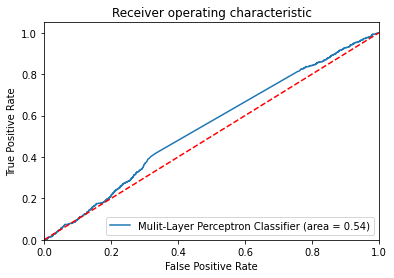

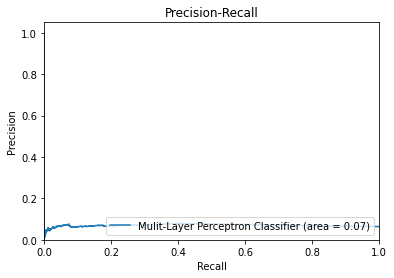

In [9]:
mlp(X_train_25, y_train, X_val_25, y_val, X_test_25, y_test, "25th quantile")

# Modelling on 50th Quantile

In [8]:
## define columns to drop
cols_to_drop_50 = ['dwelling_time_-1_25', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_75', 'std_-1_mean', 'mean_-1_25', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_25', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_25', 'std_0_75', 'std_0_mean', 'mean_0_25', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_25', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_75', 'std_+1_mean', 'mean_+1_25', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_50 = X_val.drop(columns = cols_to_drop_50, axis = 1)

## dropping columns from X_test set
X_test_50 = X_test.drop(columns = cols_to_drop_50, axis = 1)

## Load X_train_50
X_train_50_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_50.parquet" ## to edit file path
X_train_50 = pd.read_parquet(X_train_50_path)

In [ ]:
## check if training data are the same len
print(f"Number of Rows for X_train_50 and y_train: {len(X_train_50)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_50 and y_val: {len(X_val_50)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_50 and y_test: {len(X_test_50)}, {len(y_test)}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of multi-layer perceptron classifier on validation set using 50th quantile: 0.93
Accuracy of multi-layer perceptron classifier on test set using 50th quantile: 0.94


OSError: [Errno 30] Read-only file system: 'Log_ROC.png'

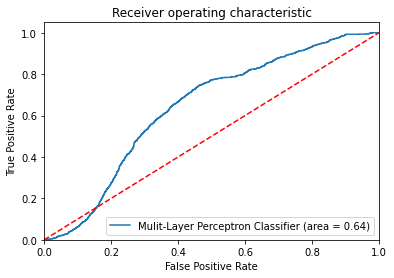

In [20]:
mlp(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile")

# Modelling on 75th Quantile

In [22]:
## define columns to drop
cols_to_drop_75 = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_50', 'std_-1_mean', 'mean_-1_25', 'mean_-1_50', 'mean_-1_mean',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_mean', 'std_0_25', 'std_0_50', 'std_0_mean', 'mean_0_25', 'mean_0_50', 'mean_0_mean',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_50', 'std_+1_mean', 'mean_+1_25', 'mean_+1_50', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_75 = X_val.drop(columns = cols_to_drop_75, axis = 1)

## dropping columns from X_test set
X_test_75 = X_test.drop(columns = cols_to_drop_75, axis = 1)

## Load X_train_75
X_train_75_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_75.parquet" ## to edit file path
X_train_75 = pd.read_parquet(X_train_75_path)

In [ ]:
## check if training data are the same len
print(f"Number of Rows for X_train_75 and y_train: {len(X_train_75)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_75 and y_val: {len(X_val_75)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_75 and y_test: {len(X_test_75)}, {len(y_test)}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of multi-layer perceptron classifier on validation set using 75th quantile: 0.93
Accuracy of multi-layer perceptron classifier on test set using 75th quantile: 0.94


OSError: [Errno 30] Read-only file system: 'Log_ROC.png'

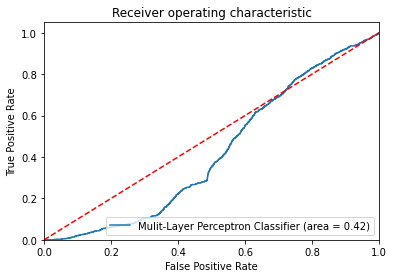

In [23]:
mlp(X_train_75, y_train, X_val_75, y_val, X_test_75, y_test, "75th quantile")

# Modelling on Mean

In [24]:
## define columns to drop
cols_to_drop_mean = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'std_-1_25', 'std_-1_50', 'std_-1_75', 'mean_-1_25', 'mean_-1_50', 'mean_-1_75',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'std_0_25', 'std_0_50', 'std_0_75', 'mean_0_25', 'mean_0_50', 'mean_0_75',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'std_+1_25', 'std_+1_50', 'std_+1_75', 'mean_+1_25', 'mean_+1_50', 'mean_+1_75']

## dropping columns from X_validation set
X_val_mean = X_val.drop(columns = cols_to_drop_mean, axis = 1)

## dropping columns from X_test set
X_test_mean = X_test.drop(columns = cols_to_drop_mean, axis = 1)

## Load X_train_mean
X_train_mean_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_mean.parquet" ## to edit file path
X_train_mean = pd.read_parquet(X_train_mean_path)

In [ ]:
## check if training data are the same len
print(f"Number of Rows for X_train_mean and y_train: {len(X_train_mean)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_mean and y_val: {len(X_val_mean)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_mean and y_test: {len(X_test_mean)}, {len(y_test)}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of multi-layer perceptron classifier on validation set using mean: 0.93
Accuracy of multi-layer perceptron classifier on test set using mean: 0.94


OSError: [Errno 30] Read-only file system: 'Log_ROC.png'

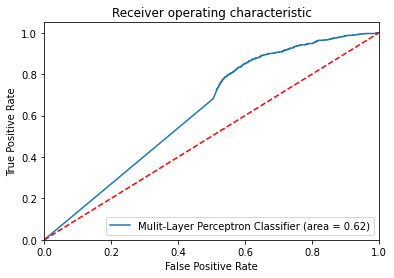

In [25]:
mlp(X_train_mean, y_train, X_val_mean, y_val, X_test_mean, y_test, "mean")

### Hyperparameter Tuning

- The optimal size of the hidden layer is usually between the size of the input and size of the output layers.
    - Input layers is the number of features (we have 37, so round off to 40)
    - Output layer has 2 nodes. 
    - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

## create classifier for randomised search
mlp_rs = MLPClassifier(random_state = 1)

## define the parameters to search through
parameters_space = {
    'max_iter': [100, 200, 300],
    'hidden_layer_sizes': [(30, ), (40, )],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': list(np.arange(0.01, 0.05, 0.005)),
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

In [ ]:
## fit the classifer for different combinations of parameters
clf_rs = RandomizedSearchCV(mlp_rs, parameters_space, n_jobs = -1, cv = 3)
clf_rs.fit(X_train_25, y_train)

In [ ]:
# print best parameter set
print('Best parameters found:\n', clf_rs.best_params_)

In [ ]:
# print parameters mean and std
means = clf_rs.cv_results_['mean_test_score']
stds = clf_rs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
y_true, y_pred = y_test , clf_rs.predict(X_test_25)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
y_pred_proba = clf_rs.predict_proba(X_test_25)[::,1]                                 
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)                           
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()